## Decision Tree Model

### Imports and Utils

In [1]:
"""
Importing the necessary libraries
"""
import os
from time import time
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import xlogy
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
"""
Utility functions for the Model
"""

def accuracy(y_true: pd.Series, y_pred: pd.Series) -> float:
    """
    y_true: pd.Series: True labels
    y_pred: pd.Series: Predicted labels

    Returns: float: Accuracy
    """

    assert y_pred.size == y_true.size
    accuracy = np.isclose(y_true.values, y_pred.values, atol=0.01).mean()
    return accuracy

def entropy(Y: pd.Series) -> float:
    """
    Y: pd.Series: Output values

    Returns: float: Entropy
    """

    vals = Y.value_counts(normalize=True)
    return -np.sum(xlogy(vals, vals))

def gini_index(Y: pd.Series) -> float:
    """
    Y: pd.Series: Output values

    Returns: float: Gini Index
    """

    vals = Y.value_counts(normalize=True)
    return 1 - np.sum(np.square(vals))

def information_gain(parent: pd.Series, left: pd.Series, right: pd.Series):
    """
    parent: pd.Series: Input parent dataset.
    left: pd.Series: Subset of the parent dataset.
    right: pd.Series: Subset of the parent dataset.

    Returns: float: Information gain.
    """

    # calculate parent and child entropy
    before_entropy = entropy(parent)
    after_entropy = (len(left) / len(parent)) * entropy(left) + (len(right) / len(parent)) * entropy(right)
        
    # calculate information gain 
    information_gain = before_entropy - after_entropy
    return information_gain

def best_split(dataset: pd.DataFrame, num_samples: int, num_features: int):
    """
    dataset: pd.DataFrame: The dataset to split.
    num_samples: int: The number of samples in the dataset.
    num_features: int: The number of features in the dataset.

    Returns: dict: A dictionary with the best split.
    """
        
    # Find the best split
    best_split = {'gain': -1, 'feature': None, 'threshold': None, "left_dataset": None, "right_dataset": None}
    for feature_index in range(num_features):
        feature_values = dataset.iloc[:, feature_index]
        thresholds = np.unique(feature_values)
        for threshold in thresholds:
            left_dataset, right_dataset = split_data(dataset, feature_index, threshold)
            y, left_y, right_y = dataset.iloc[:, -1], left_dataset.iloc[:, -1], right_dataset.iloc[:, -1]
            gain = information_gain(y, left_y, right_y)
            if gain > best_split["gain"]:
                best_split["gain"] = gain
                best_split["feature"] = feature_index
                best_split["threshold"] = threshold
                best_split["left_dataset"] = left_dataset
                best_split["right_dataset"] = right_dataset
    return best_split

def split_data(dataset: pd.DataFrame, feature: int, threshold: float):
    """
    dataset: pd.DataFrame: Input dataset.
    feature: int: Index of the feature to be split on.
    threshold: float: Threshold value to split the feature on.

    Returns:
        left_dataset: pd.DataFrame: Subset of the dataset.
        right_dataset: pd.DataFrame: Subset of the dataset.
    """
    # Create mask of the dataset using threshold
    mask = (dataset.iloc[:, feature] <= threshold)

    # Mask the dataset
    left_dataset = dataset[mask]
    right_dataset = dataset[~mask]
    return left_dataset, right_dataset

### Dataset Loading and Preprocessing

In [3]:
# Reading the data
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
dataset = pd.read_csv(url, delim_whitespace=True, header=None,names=["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "model year", "origin", "car name"])

# Cleaning the data
dataset = dataset.drop(columns=["car name", "origin"]).replace('?', np.nan).dropna()
dataset['horsepower'] = pd.to_numeric(dataset['horsepower'])

# Print the first few records
print(dataset.head())

# Print the size of the dataset
print("size of the dataset: ", dataset.shape)

    mpg  cylinders  displacement  horsepower  weight  acceleration  model year
0  18.0          8         307.0       130.0  3504.0          12.0          70
1  15.0          8         350.0       165.0  3693.0          11.5          70
2  18.0          8         318.0       150.0  3436.0          11.0          70
3  16.0          8         304.0       150.0  3433.0          12.0          70
4  17.0          8         302.0       140.0  3449.0          10.5          70
size of the dataset:  (392, 7)


In [4]:
# Extract X and Y from dataset
X = dataset.drop(columns=["mpg"])
Y = dataset["mpg"]

# Normalize the dataset
# X = pd.DataFrame(preprocessing.normalize(X, axis=0), columns=X.columns)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=42)

# Print the first few records
print(f'Feature Train Dataset:\n{X_train.head()}\nsize: {X_train.shape}\n')
print(f'Target Train Dataset:\n{Y_train.head()}\nsize: {Y_train.shape}\n')
print(f'Feature Test Dataset:\n{X_test.head()}\nsize: {X_test.shape}\n')
print(f'Target Test Dataset:\n{Y_test.head()}\nsize: {Y_test.shape}\n')

Feature Train Dataset:
     cylinders  displacement  horsepower  weight  acceleration  model year
260          6         225.0       110.0  3620.0          18.7          78
184          4         140.0        92.0  2572.0          14.9          76
174          6         171.0        97.0  2984.0          14.5          75
64           8         318.0       150.0  4135.0          13.5          72
344          4          86.0        64.0  1875.0          16.4          81
size: (313, 6)

Target Train Dataset:
260    18.6
184    25.0
174    18.0
64     15.0
344    39.0
Name: mpg, dtype: float64
size: (313,)

Feature Test Dataset:
     cylinders  displacement  horsepower  weight  acceleration  model year
79           4          96.0        69.0  2189.0          18.0          72
276          4         121.0       115.0  2795.0          15.7          78
248          4          91.0        60.0  1800.0          16.4          78
56           4          91.0        70.0  1955.0          20.5     

### Model Creation and Training

In [5]:
class Node():
    """
    A class representing a node in a decision tree.
    """

    def __init__(self, feature=None, threshold=None, left=None, right=None, gain=None, value=None):
        """
        feature: string: The feature used for splitting at this node.
        threshold: List of float: The threshold used for splitting at this node.
        left: Node: Pointer to the left Node.
        Right: Node: Pointer to the Right Node.
        gain: float: The gain of the split.
        value: float: predicted value at this node.
        """

        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.gain = gain
        self.value = value

In [6]:
class DecisionTree():
    """
    A decision tree classifier.
    """

    def __init__(self, min_samples=2, max_depth=2):
        """
        Constructor for DecisionTree class.

        min_samples: int: Minimum number of samples at leaf node.
        max_depth: int: Maximum depth of the decision tree.
        """
        self.min_samples = min_samples
        self.max_depth = max_depth
    
    def build_tree(self, dataset: pd.DataFrame, current_depth=0):
        """
        dataset: pd.DataFrame: The dataset to build the tree.
        current_depth: int: The current depth of the tree.

        Returns: Node: The root node of the decision tree.
        """
        
        # split the dataset into X, y values
        X, y = dataset.iloc[:, :-1], dataset.iloc[:, -1]
        n_samples, n_features = X.shape
        
        # Terminating conditions
        if n_samples >= self.min_samples and current_depth <= self.max_depth:
            best_split_values = best_split(dataset, n_samples, n_features)
            left_node = self.build_tree(best_split_values["left_dataset"], current_depth + 1)
            right_node = self.build_tree(best_split_values["right_dataset"], current_depth + 1)

            return Node(best_split_values["feature"], best_split_values["threshold"], left_node, right_node, best_split_values["gain"])

        # compute leaf node value
        leaf_value = y.median()
        return Node(value=leaf_value)
    
    def fit(self, X: pd.DataFrame, y: pd.Series):
        """
        X: pd.DataFrame: The feature datset.
        y: pd.Series: The target values.
        """
        
        dataset = pd.concat([X, y], axis=1) 
        self.root = self.build_tree(dataset)

    def predict(self, X: pd.DataFrame):
        """
        X: pd.DataFrame: The feature matrix to make predictions for.

        Returns:
        list: A list of predicted class labels.
        """
        
        predictions = X.apply(self.traverse_tree, axis=1, args=(self.root,))
        return predictions
    
    def traverse_tree(self, X: pd.Series, node: Node):
        """
        X: pd.Series: The feature vector to predict the target value for.
        node: Node: The current node being evaluated.

        Returns: float: The predicted target value.
        """
        
        if node.value is not None: # if the node is a leaf node
            return node.value
        else: # if the node is not a leaf node
            feature = X.iloc[node.feature]
            if feature <= node.threshold:
                return self.traverse_tree(X, node.left)
            else:
                return self.traverse_tree(X, node.right)
            
    def plot_tree(self, node=None, depth=0):
        """
        Plot the decision tree.
        """
        
        if node is None:
            node = self.root

        if node.value is not None:
            print(f"{4*depth * '  '}Predict: {round(node.value, 3)}")
        else:
            print(f"{4*depth * '  '}?(column {node.feature} <= {round(node.threshold, 3)})")
            self.plot_tree(node.left, depth + 1)
            self.plot_tree(node.right, depth + 1)

In [7]:
# Defining the model for Decision Tree
model = DecisionTree(min_samples=10, max_depth=3)

In [8]:
# Training the model
model.fit(X_train, Y_train)

# Calculating the metrics
Y_pred = model.predict(X_train)
print(f"Train MSE: {mean_squared_error(Y_train, Y_pred)}")

Train MSE: 10.152284345047923


In [9]:
# Plotting the Decision Tree
model.plot_tree()

?(column 0 <= 4)
        ?(column 3 <= 2219.0)
                ?(column 5 <= 78)
                        ?(column 5 <= 76)
                                Predict: 29.75
                                Predict: 31.5
                        ?(column 5 <= 80)
                                Predict: 34.5
                                Predict: 36.0
                ?(column 5 <= 77)
                        ?(column 5 <= 76)
                                Predict: 23.5
                                Predict: 24.5
                        ?(column 4 <= 16.0)
                                Predict: 29.4
                                Predict: 28.0
        ?(column 5 <= 75)
                ?(column 0 <= 6)
                        ?(column 4 <= 16.5)
                                Predict: 18.0
                                Predict: 16.0
                        ?(column 3 <= 4135.0)
                                Predict: 14.0
                                Predict: 13.0
             

### Testing and Plotting

In [10]:
# Predicting the values
Y_pred = model.predict(X_test)

# Calculating the metrics
print(f'Test MSE: {mean_squared_error(Y_test, Y_pred)}')

Test MSE: 11.731139240506327


In [11]:
# Specify the directory you want to save in
directory = "Models"
os.makedirs(directory, exist_ok=True)

# Train the model with different hyperparameters
Metrics = {}
for depth in range(0, 7):
    print(f"Decision Tree for max depth of {depth}")

    # Defining the model for Decision Tree
    model = DecisionTree(min_samples=10, max_depth=depth)
    start = time()
    model.fit(X_train, Y_train)
    end = time()
    train_time = end - start

    # Calculating the metrics
    Y_pred = model.predict(X_train)
    train_mse = mean_squared_error(Y_train, Y_pred)
    start = time()
    Y_pred = model.predict(X_test)
    end = time()
    predict_time = end - start
    test_mse = mean_squared_error(Y_test, Y_pred)

    # Storing the metrics
    Metrics[depth] = {"Train MSE": train_mse, "Test MSE": test_mse, "Train Time": train_time, "Predict Time": predict_time}
    print(f"Train MSE: {train_mse}")
    print(f"Test MSE: {test_mse}")

    # Saving the model
    filepath = os.path.join(directory, f"DecisionTree_{depth}.pkl")
    with open(filepath, "wb") as file:
        pickle.dump(model, file)
    print("\n------------------------------------------------------------\n")

Metrics = pd.DataFrame(Metrics).T


Decision Tree for max depth of 0
Train MSE: 27.178466453674123
Test MSE: 23.429493670886075

------------------------------------------------------------

Decision Tree for max depth of 1
Train MSE: 18.51995207667732
Test MSE: 18.967626582278477

------------------------------------------------------------

Decision Tree for max depth of 2
Train MSE: 12.010718849840254
Test MSE: 11.470917721518985

------------------------------------------------------------

Decision Tree for max depth of 3
Train MSE: 10.152284345047923
Test MSE: 11.731139240506327

------------------------------------------------------------

Decision Tree for max depth of 4
Train MSE: 9.19894568690096
Test MSE: 11.226455696202532

------------------------------------------------------------

Decision Tree for max depth of 5
Train MSE: 8.6991214057508
Test MSE: 11.559588607594936

------------------------------------------------------------

Decision Tree for max depth of 6
Train MSE: 8.301757188498403
Test MSE: 11.7

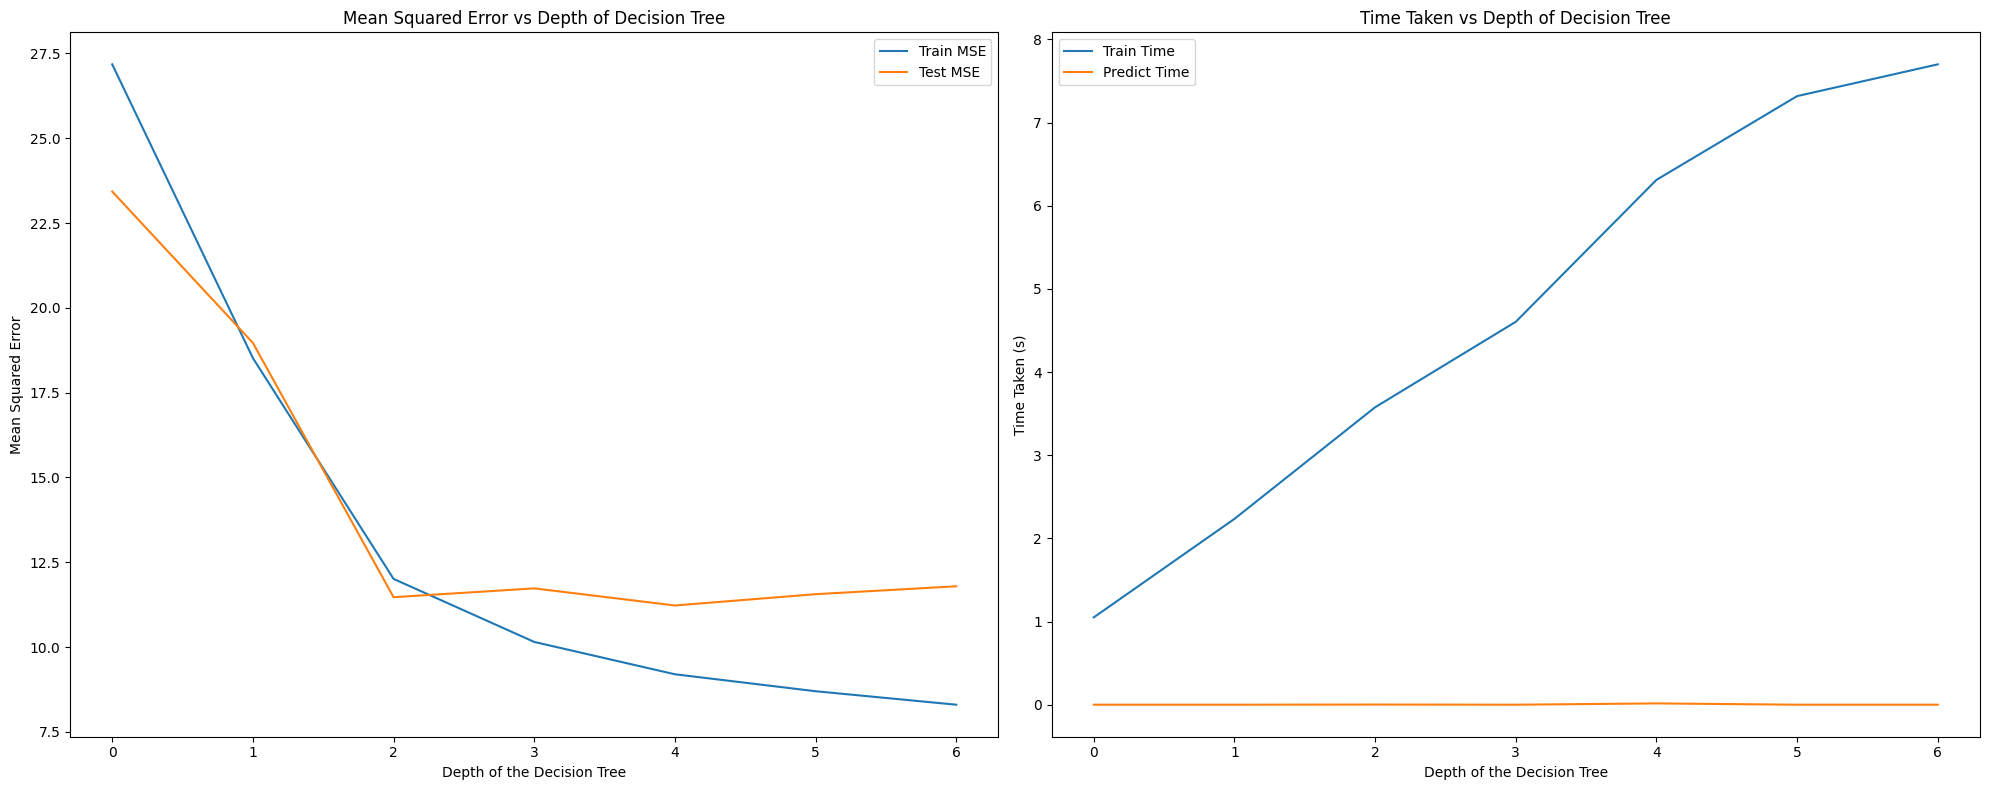

In [17]:
# Plotting the metrics
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

Metrics.iloc[:, :2].plot(ax=axs[0])
axs[0].set_xlabel('Depth of the Decision Tree')
axs[0].set_ylabel('Mean Squared Error')
axs[0].set_title('Mean Squared Error vs Depth of Decision Tree')

Metrics.iloc[:, 2:].plot(ax=axs[1])
axs[1].set_xlabel('Depth of the Decision Tree')
axs[1].set_ylabel('Time Taken (s)')
axs[1].set_title('Time Taken vs Depth of Decision Tree')

plt.tight_layout()
plt.show()